# Preprocessing steps for _GlobalPID_ models (for isMuon=False)

In [1]:
import os
from IPython.display import Markdown

PARTICLE = os.environ.get("PARTICLE", "muon")
LOCAL = os.environ.get("LOCAL", "yes").lower() in ['y', 'yes', 'true', '1']
SAMPLE = os.environ.get("SAMPLE", "2016MU")

Markdown(f"""
 * PARTICLE: `{PARTICLE}`
 * LOCAL: `{LOCAL}`
 * SAMPLE: `{SAMPLE}`
""")


 * PARTICLE: `muon`
 * LOCAL: `True`
 * SAMPLE: `2016MU`


### Technologies and libraries

On top of the standard Python echosystem we are using:
 * `uproot` to convert data from `ROOT TTrees` to `pandas DataFrames`
 * `dask DataFrame` to enable processing datasets larger than the available RAM. Dask takes care of flushing from disk to RAM the data, converting from ROOT to pandas data format on demand.
 * `Arrow Feather` data format to cache in local storage the training dataset
     * Note that custom wrappers to Dask and TensorFlow, as defined in `feather_io.py` are needed 

In [2]:
import uproot
import numpy as np
import pandas as pd
import dask.dataframe as ddf
import matplotlib.pyplot as plt

from os import environ

### Loading data

In [3]:
from glob import glob

if LOCAL:
    if SAMPLE == "2016MU":
        file_pattern = "/tmp/LamarrTraining-j109*.root"
        default_file_list = glob(file_pattern)[:3]
else:
    # file_pattern = "/workarea/cloud-storage/anderlinil/LamarrBenderTrain/j109/*.root"
    default_file_list = []
    
file_list = os.environ.get("INPUT_FILES", " ".join(default_file_list)).split(" ")

print (f"Found {len(file_list)} data files")  

Found 3 data files


#### Conversion from `ROOT TTree` to `Pandas DataFrame`

In [5]:
selections = [
  "probe_Brunel_P > 3000",
  "probe_Brunel_P < 200000", 
  "probe_Brunel_ETA > 1.5", 
  "probe_Brunel_ETA < 5.5",
  "probe_Brunel_isMuon == 0",
  "probe_Brunel_RichDLLe  > -150",
  "probe_Brunel_RichDLLmu > -150",
  "probe_Brunel_RichDLLk  > -150",
  "probe_Brunel_RichDLLp  > -150",
  "probe_Brunel_RichDLLe  <  150",
  "probe_Brunel_RichDLLmu <  150",
  "probe_Brunel_RichDLLk  <  150",
  "probe_Brunel_RichDLLp  <  150",
  "probe_Brunel_PIDe  > -25", 
  "probe_Brunel_PIDK  > -150", 
  "probe_Brunel_PIDp  > -150",
  "probe_Brunel_MC15TuneV1_ProbNNe  >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNpi >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNk  >= 0", 
  "probe_Brunel_MC15TuneV1_ProbNNp  >= 0", 
  "nTracks_Brunel > 0",
  "nTracks_Brunel < 1000",
  "probe_Brunel_MuonUnbiased == 1",
]

cuts = " and ".join([f"({s})" for s in selections])

In [6]:
from functools import partial

opened_files = [uproot.open(f) for f in file_list]

sim = (
    ddf.from_map(
        lambda f: pd.DataFrame(f[f"PidTupler/pid_{PARTICLE}"].arrays(library='np')),
        opened_files,
    ).query(cuts)
)


### Features

In [7]:
sim["p_GeV"] = sim.probe_Brunel_P/1e3
# sim["log10_p"] = np.log10(sim.probe_Brunel_P)
sim["eta"] = sim.probe_Brunel_ETA

sim= sim.map_partitions(lambda df: df.assign(nTracks_f = df.nTracks_Brunel + np.random.uniform(-0.5, 0.5, len(df))))
sim["charge"] = sim.probe_Brunel_trackcharge
sim["RichDLLe"] = sim.probe_Brunel_RichDLLe
sim["RichDLLmu"] = sim.probe_Brunel_RichDLLmu
sim["RichDLLk"] = sim.probe_Brunel_RichDLLk
sim["RichDLLp"] = sim.probe_Brunel_RichDLLp

sim["PIDe"] = sim.probe_Brunel_PIDe
sim["PIDK"] = sim.probe_Brunel_PIDK
sim["PIDp"] = sim.probe_Brunel_PIDp
sim["ProbNNe"] = sim.probe_Brunel_MC15TuneV1_ProbNNe
sim["ProbNNpi"] = sim.probe_Brunel_MC15TuneV1_ProbNNpi
sim["ProbNNk"] = sim.probe_Brunel_MC15TuneV1_ProbNNk
sim["ProbNNp"] = sim.probe_Brunel_MC15TuneV1_ProbNNp
sim["PIDmu"] = sim.probe_Brunel_PIDmu

In [8]:
real_conditions = ["p_GeV", "eta", "nTracks_f", "RichDLLe", "RichDLLmu", "RichDLLk", "RichDLLp"]
flag_conditions = ["charge"]

conditions = real_conditions + flag_conditions
target = ["PIDe", "PIDK", "PIDp", "ProbNNe", "ProbNNpi", "ProbNNk", "ProbNNp", "PIDmu"]

In [9]:
from IPython.display import HTML

def list_vars(title, var_list):
    display(HTML (f"<P><B>{title}</B><UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in var_list) + "</UL><HR>"))

list_vars("Input features (real)", real_conditions)
list_vars("Input features (boolean)", flag_conditions)
list_vars("Output features (real)", target)

In [10]:
npartitions=min(len(file_list), 10)
dfs = dict()

dfs = sim[conditions + target].head(500_000, npartitions=npartitions)
print(f"Number of {part}s:", len(dfs))

Number of muons: 65350
Number of pions: 500000
Number of kaons: 500000
Number of protons: 500000


#### Histograms

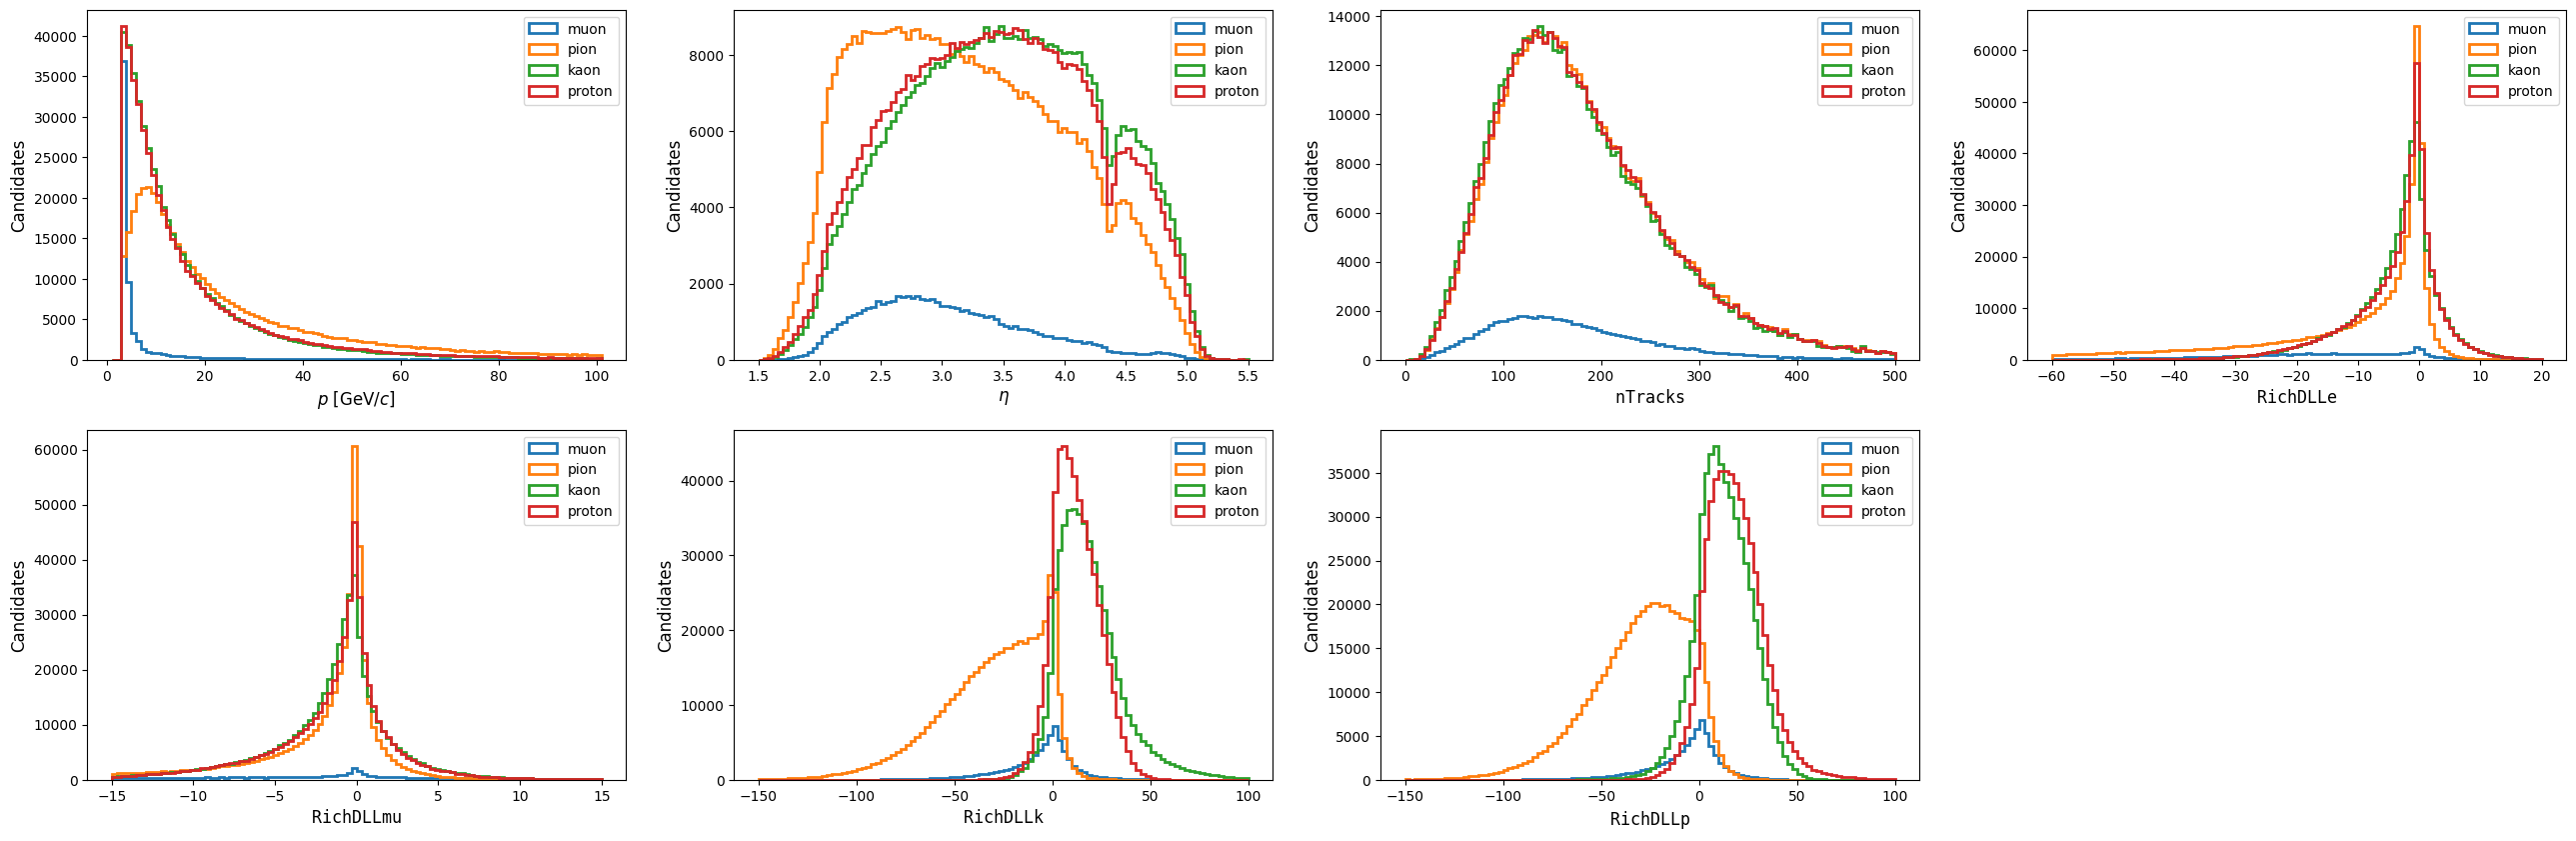

In [11]:
plt.figure(figsize=(32, 10), dpi=100)

plt.subplot(2, 4, 1)
plt.xlabel(r"$p$ [GeV/$c$]", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["p_GeV"], bins=np.linspace(1.0, 101.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(2, 4, 2)
plt.xlabel(r"$\eta$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["eta"], bins=np.linspace(1.5, 5.5, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(2, 4, 3)
plt.xlabel(r"$\mathtt{nTracks}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["nTracks_f"], bins=np.linspace(0.0, 500.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(2, 4, 4)
plt.xlabel(r"$\mathtt{RichDLLe}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["RichDLLe"], bins=np.linspace(-60.0, 20.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.subplot(2, 4, 5)
plt.xlabel(r"$\mathtt{RichDLLmu}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["RichDLLmu"], bins=np.linspace(-15.0, 15.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.subplot(2, 4, 6)
plt.xlabel(r"$\mathtt{RichDLLk}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["RichDLLk"], bins=np.linspace(-150.0, 100.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(2, 4, 7)
plt.xlabel(r"$\mathtt{RichDLLp}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["RichDLLp"], bins=np.linspace(-150.0, 100.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.show()

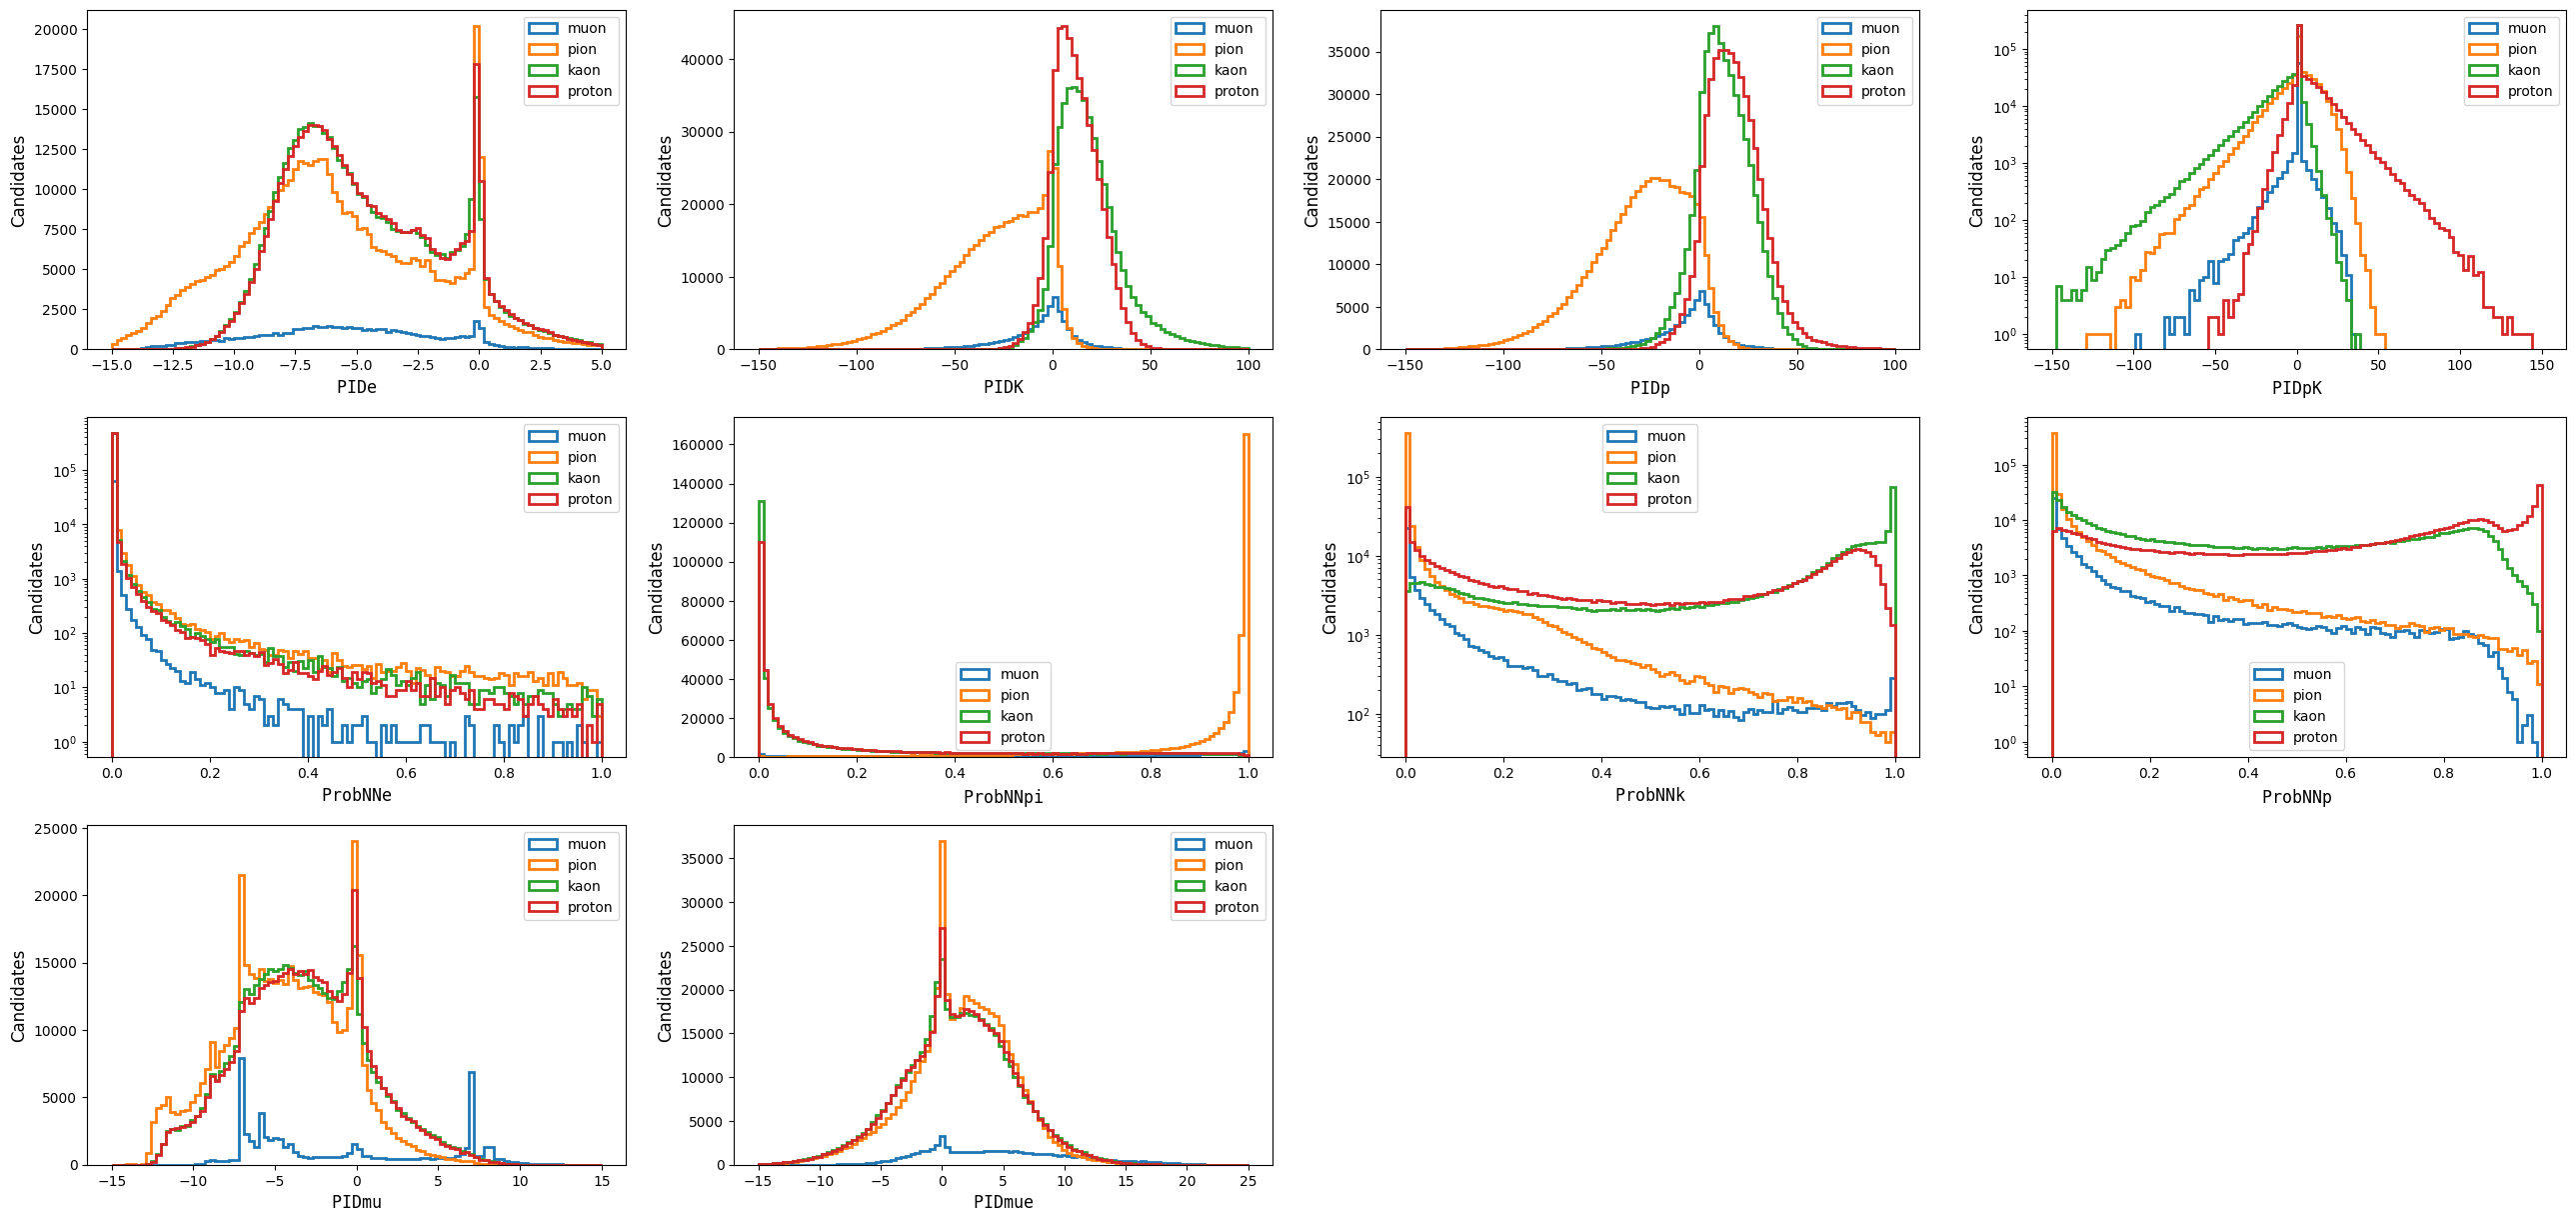

In [12]:
plt.figure(figsize=(32, 15), dpi=100)

plt.subplot(3, 4, 1)
plt.xlabel(r"$\mathtt{PIDe}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["PIDe"], bins=np.linspace(-15.0, 5.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 2)
plt.xlabel(r"$\mathtt{PIDK}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["PIDK"], bins=np.linspace(-150.0, 100.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 3)
plt.xlabel(r"$\mathtt{PIDp}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["PIDp"], bins=np.linspace(-150.0, 100.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 4)
plt.xlabel(r"$\mathtt{PIDpK}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["PIDp"] - dfs["PIDK"], bins=np.linspace(-150.0, 150.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 5)
plt.xlabel(r"$\mathtt{ProbNNe}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["ProbNNe"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 6)
plt.xlabel(r"$\mathtt{ProbNNpi}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["ProbNNpi"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 7)
plt.xlabel(r"$\mathtt{ProbNNk}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["ProbNNk"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 8)
plt.xlabel(r"$\mathtt{ProbNNp}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["ProbNNp"], bins=np.linspace(0.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(3, 4, 9)
plt.xlabel(r"$\mathtt{PIDmu}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["PIDmu"], bins=np.linspace(-15.0, 15.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(3, 4, 10)
plt.xlabel(r"$\mathtt{PIDmue}$", fontsize=12)
plt.ylabel(r"Candidates", fontsize=12)
plt.hist(dfs["PIDmu"] - dfs["PIDe"], bins=np.linspace(-15.0, 25.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
# plt.yscale("log")

plt.show()

### Preprocessing

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler

n_features = len(real_conditions)
n_flags = len(flag_conditions)
n_target = len(target)

prep_step_x = ColumnTransformer(
    [
        ('quantile', QuantileTransformer(output_distribution='normal'), np.arange(n_features)),
        ('flags', "passthrough", n_features + np.arange(n_flags)),
    ]
).fit(dfs[conditions].values)

prep_step_y = ColumnTransformer(
    [
        ('standard', StandardScaler(), [0, 1, 2, 7]),
        ('probs', MinMaxScaler(feature_range=(-1.0, 1.0)), [3, 4, 5, 6]),
    ]
).fit(dfs[target].values)

In [14]:
from preprocessing_utils import store_as_pickle

display(
    store_as_pickle(
        prep_step_x,
        f"PREPROCESSING_X",
        f"/tmp/lb-pidsim-train/models/GlobalPID-nm_{PARTICLE}_models/tX_{SAMPLE}.pkl",
    )
)
display(
    store_as_pickle(
        prep_step_y,
        f"PREPROCESSING_Y",
        f"/tmp/lb-pidsim-train/models/GlobalPID-nm_{PARTICLE}_models/tY_{SAMPLE}.pkl",
    )
)

2025-08-17 11:00:38.629655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-17 11:00:38.820753: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-17 11:00:38.822946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-17 11:00:39.217057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-17 11:00:40.950799: W tensorflow/compiler/tf

### Train, test and validation

The dataset is split in:
 * *train* (50%) used for training the model
 * *test* (40%) used for measuring the performance of the model
 * *validation* (10%) used in combination with the train dataset to check for overtraining effects
 
Split data is stored on disk in chunks of 100 MB (before compression).

In [15]:
DATA_PATH = os.environ.get("DATA_PATH", "/tmp/lb-pidsim-train/data")
os.makedirs(DATA_PATH, exist_ok=True)

In [ ]:
from preprocessing_utils import split_and_store, peek_from_dataset
from math import ceil
from IPython.display import Markdown

display(Markdown(f"# {PARTICLE.capitalize()}"))

entries = split_and_store(
    sim[conditions + target],
    [
        (0.5, os.environ.get(f"TRAIN", f"{DATA_PATH}/GlobalPID-nm-{PARTICLE}-{SAMPLE}-train")),
        (0.4, os.environ.get(f"TEST", f"{DATA_PATH}/GlobalPID-nm-{PARTICLE}-{SAMPLE}-test")),
        (0.1, os.environ.get(f"VALIDATION", f"{DATA_PATH}/GlobalPID-nm-{PARTICLE}-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions,
    labels=target,
    preprocessorX=prep_step_x,
    preprocessorY=prep_step_y,
)
    
display(pd.DataFrame(entries, index=["Train", "Test", "Validation"]))

X, y = peek_from_dataset(      
    f"TRAIN", 
    f"{DATA_PATH}/GlobalPID-nm-{PARTICLE}-{SAMPLE}-train",
)
 
## X Variables
plt.figure(figsize=(32, 10), dpi=100)

for i, x_var in enumerate(conditions):
    plt.subplot(2, ceil(len(conditions)/2), i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X[:, i].numpy()[:100000], bins=100)

plt.show()

## Y variables
reord_target = ["PIDe", "PIDK", "PIDp", "PIDmu", "ProbNNe", "ProbNNpi", "ProbNNk", "ProbNNp"]

plt.figure(figsize=(32, 15), dpi=100)


for i, y_var in enumerate(reord_target):
    plt.subplot(3, 4, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y[:, i].numpy()[:100000], bins=100)

plt.subplot(3, 4, 9)
plt.xlabel("PIDpK", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y[:, 2].numpy()[:100000] - y[:, 1].numpy()[:100000], bins=100)

plt.subplot(3, 4, 10)
plt.xlabel("PIDmue", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y[:, 3].numpy()[:100000] - y[:, 0].numpy()[:100000], bins=100)

plt.show()